In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# reading the datasets into pandas

stock_price = pd.read_csv('/content/AAPL.CSV')
# displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-01,79.437500,80.587502,79.302498,80.462502,78.891678,80791200
1,2020-06-02,80.187500,80.860001,79.732498,80.834999,79.256920,87642800
2,2020-06-03,81.165001,81.550003,80.574997,81.279999,79.693230,104491200
3,2020-06-04,81.097504,81.404999,80.195000,80.580002,79.006889,87560400
4,2020-06-05,80.837502,82.937500,80.807503,82.875000,81.257088,137250400


In [3]:
stock_headlines = pd.read_csv('/content/India-News-Headlines001.csv')
# displaying stock news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,02/01/2001,unknown,Status quo will not be disturbed at Ayodhya; s...
1,03/01/2001,unknown,Fissures in Hurriyat over Pak visit
2,04/01/2001,unknown,America's unwanted heading for India?
3,05/01/2001,unknown,For bigwigs; it is destination Goa
4,06/01/2001,unknown,Extra buses to clear tourist traffic


**Feature Engineering**

In [4]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(842, 1048575)

In [5]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

**Stock Price Data**

In [6]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-06-01,80.462502,79.437500,80.587502,79.302498,80791200
2020-06-02,80.834999,80.187500,80.860001,79.732498,87642800
2020-06-03,81.279999,81.165001,81.550003,80.574997,104491200
2020-06-04,80.580002,81.097504,81.404999,80.195000,87560400
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400
...,...,...,...,...,...
2023-09-27,170.429993,172.619995,173.039993,169.050003,66921800
2023-09-28,170.690002,169.339996,172.029999,167.619995,56294400
2023-09-29,171.210007,172.020004,173.070007,170.339996,51814200


**Stock News Headlines Data**

In [7]:
import pandas as pd

# Assuming stock_headlines is your DataFrame
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date'], errors='coerce')

# Drop rows with invalid dates
stock_headlines = stock_headlines.dropna(subset=['publish_date'])

# Continue with your existing processing logic
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
stock_headlines.set_index('publish_date', inplace=True)
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)

# Print or use stock_headlines as needed
print(stock_headlines)


                                              headline_text
publish_date                                               
2001-01-02             Extra buses to clear tourist traffic
2001-01-03    A noisy effort to spruce up Commercial Street
2001-01-04      Vajpayee wants to put reforms on fast track
2001-01-05                        BCC holds talks on budget
2001-01-06                      Akashdeep: Ghaath Ka Saath!
...                                                     ...
2262-04-07       YESTERDAYS EDITORIALSbrUnqualified Anarchy
2262-04-08                 Cop; MCC man killed in encounter
2262-04-09              Weather to blame for Scindia mishap
2262-04-10              Investors get raw deal on gold card
2262-04-11            This Sainik is a peaceniks' nightmare

[95428 rows x 1 columns]


**Combined Stock Data**

In [8]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-06-01,80.462502,79.437500,80.587502,79.302498,80791200.0,MPs; rly minister to review Kerala rail projects
2020-06-02,80.834999,80.187500,80.860001,79.732498,87642800.0,Jowar; ragi to be included in PDS
2020-06-03,81.279999,81.165001,81.550003,80.574997,104491200.0,Mystery shrouds ABVP student leader's disappea...
2020-06-04,80.580002,81.097504,81.404999,80.195000,87560400.0,AIISH's hi-tech library opening today
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,Shahi Imam's blessings
...,...,...,...,...,...,...
2023-09-27,170.429993,172.619995,173.039993,169.050003,66921800.0,Traders to hold bandh against Rent Act proposals
2023-09-28,170.690002,169.339996,172.029999,167.619995,56294400.0,Muslim forum chief blasts Lucknow SSP
2023-09-29,171.210007,172.020004,173.070007,170.339996,51814200.0,Bangalore couple offers to adopt 4 cows
2023-10-02,173.750000,171.220001,174.300003,170.929993,52164500.0,182 Ashraya houses to be constructed


**Calculating Sentiment Scores**

In [9]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-06-01,80.462502,79.437500,80.587502,79.302498,80791200.0,MPs; rly minister to review Kerala rail projects,,,,
2020-06-02,80.834999,80.187500,80.860001,79.732498,87642800.0,Jowar; ragi to be included in PDS,,,,
2020-06-03,81.279999,81.165001,81.550003,80.574997,104491200.0,Mystery shrouds ABVP student leader's disappea...,,,,
2020-06-04,80.580002,81.097504,81.404999,80.195000,87560400.0,AIISH's hi-tech library opening today,,,,
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,Shahi Imam's blessings,,,,


In [10]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-06-01,80.462502,79.437500,80.587502,79.302498,80791200.0,MPs; rly minister to review Kerala rail projects,0.0000,0.0,1.000,0.000
2020-06-02,80.834999,80.187500,80.860001,79.732498,87642800.0,Jowar; ragi to be included in PDS,0.0000,0.0,1.000,0.000
2020-06-03,81.279999,81.165001,81.550003,80.574997,104491200.0,Mystery shrouds ABVP student leader's disappea...,0.0000,0.0,1.000,0.000
2020-06-04,80.580002,81.097504,81.404999,80.195000,87560400.0,AIISH's hi-tech library opening today,0.0000,0.0,1.000,0.000
2020-06-05,82.875000,80.837502,82.937500,80.807503,137250400.0,Shahi Imam's blessings,0.5423,0.0,0.364,0.636


**Finalising Stock Data and writing to Disk**

In [11]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-06-01,80.462502,0.0000,0.0,1.000,0.000,79.437500,80.587502,79.302498,80791200.0
2020-06-02,80.834999,0.0000,0.0,1.000,0.000,80.187500,80.860001,79.732498,87642800.0
2020-06-03,81.279999,0.0000,0.0,1.000,0.000,81.165001,81.550003,80.574997,104491200.0
2020-06-04,80.580002,0.0000,0.0,1.000,0.000,81.097504,81.404999,80.195000,87560400.0
2020-06-05,82.875000,0.5423,0.0,0.364,0.636,80.837502,82.937500,80.807503,137250400.0


In [12]:
# writing the prepared stock_data to disk
stock_data.to_csv('/content/Stock_DataFinal001.csv')

In [13]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/Stock_DataFinal001.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-01,80.462502,0.0000,0.0,1.000,0.000,79.437500,80.587502,79.302498,80791200.0
2020-06-02,80.834999,0.0000,0.0,1.000,0.000,80.187500,80.860001,79.732498,87642800.0
2020-06-03,81.279999,0.0000,0.0,1.000,0.000,81.165001,81.550003,80.574997,104491200.0
2020-06-04,80.580002,0.0000,0.0,1.000,0.000,81.097504,81.404999,80.195000,87560400.0
2020-06-05,82.875000,0.5423,0.0,0.364,0.636,80.837502,82.937500,80.807503,137250400.0


** Feature Engineering of Stock Data**

In [14]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(842, 9)

In [15]:
# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [16]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,8.420000e+02
mean,145.874938,-0.034349,0.105773,0.813314,0.080913,145.777180,147.483106,144.143325,9.263028e+07
std,24.243520,0.317605,0.192670,0.226200,0.161549,24.223200,24.326825,24.176158,4.259782e+07
min,80.462502,-0.897900,0.000000,0.167000,0.000000,79.437500,80.587502,79.302498,3.145820e+07
25%,129.612500,0.000000,0.000000,0.635000,0.000000,128.952499,130.627506,127.415003,6.479580e+07
50%,146.849998,0.000000,0.000000,1.000000,0.000000,146.875000,148.535004,145.525002,8.254005e+07
75%,164.914997,0.000000,0.195750,1.000000,0.000000,164.412498,166.317505,162.800003,1.081673e+08
max,196.449997,0.807400,0.833000,1.000000,0.762000,196.240005,198.229996,195.279999,3.743368e+08


In [17]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842 entries, 2020-06-01 to 2023-10-03
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     842 non-null    float64
 1   compound  842 non-null    float64
 2   negative  842 non-null    float64
 3   neutral   842 non-null    float64
 4   positive  842 non-null    float64
 5   Open      842 non-null    float64
 6   High      842 non-null    float64
 7   Low       842 non-null    float64
 8   Volume    842 non-null    float64
dtypes: float64(9)
memory usage: 65.8+ KB


**EDA of Stock Data**

Text(0, 0.5, 'Close Price ($)')

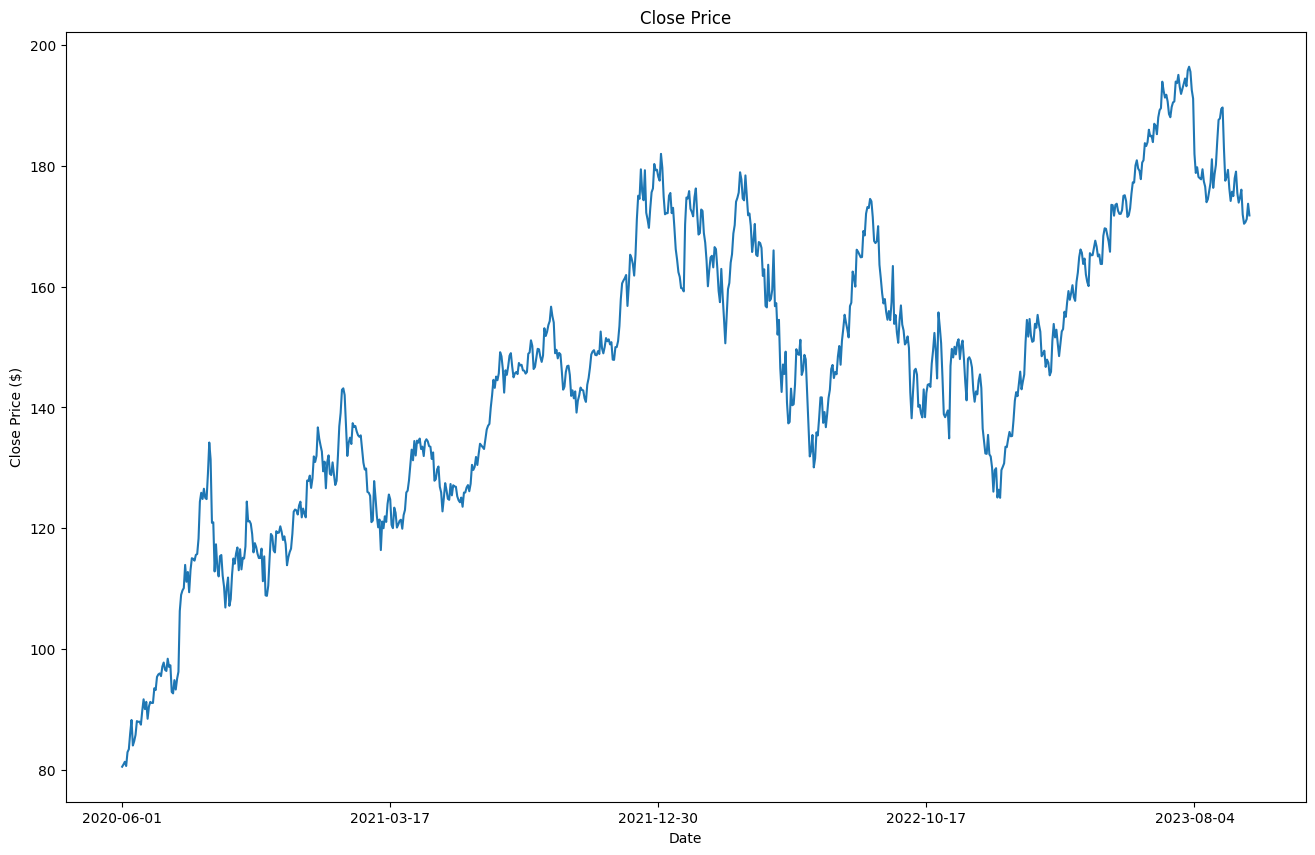

In [18]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [19]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09,82.199285,0.092986,0.042286,0.810571,0.147143,81.188930,82.448929,80.777857,1.058718e+08
2020-06-10,83.306071,0.024886,0.097000,0.755857,0.147143,82.265716,83.606785,81.809286,1.181376e+08
2020-06-11,83.754642,0.102357,0.097000,0.689143,0.213857,83.285715,84.593214,82.400358,1.344261e+08


<Axes: xlabel='Date'>

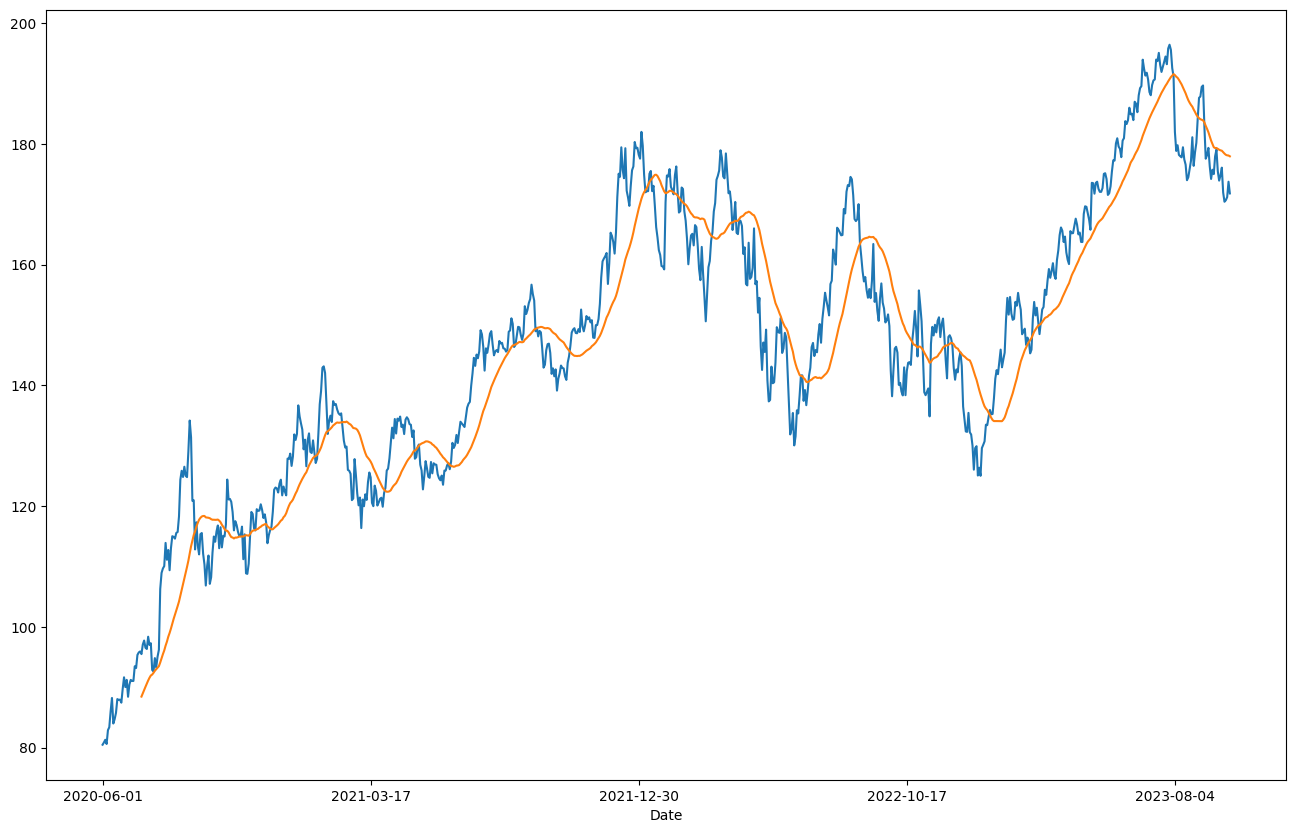

In [20]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [21]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-06-01,80.462502,0.0000,0.000,1.000,0.000,79.437500,80.587502,79.302498,80791200.0
2020-06-02,80.834999,0.0000,0.000,1.000,0.000,80.187500,80.860001,79.732498,87642800.0
2020-06-03,81.279999,0.0000,0.000,1.000,0.000,81.165001,81.550003,80.574997,104491200.0
2020-06-04,80.580002,0.0000,0.000,1.000,0.000,81.097504,81.404999,80.195000,87560400.0
2020-06-05,82.875000,0.5423,0.000,0.364,0.636,80.837502,82.937500,80.807503,137250400.0
...,...,...,...,...,...,...,...,...,...
2023-09-27,170.429993,0.0000,0.000,1.000,0.000,172.619995,173.039993,169.050003,66921800.0
2023-09-28,170.690002,0.0000,0.000,1.000,0.000,169.339996,172.029999,167.619995,56294400.0
2023-09-29,171.210007,0.1779,0.000,0.746,0.254,172.020004,173.070007,170.339996,51814200.0


**Data Preparation for Modelling**

In [22]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 672
Number of records in Test Data: 170


In [23]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-06-02     80.834999
2020-06-03     81.279999
2020-06-04     80.580002
2020-06-05     82.875000
2020-06-08     83.364998
                 ...    
2023-09-27    170.429993
2023-09-28    170.690002
2023-09-29    171.210007
2023-10-02    173.750000
2023-10-03    171.809998
Name: Close, Length: 841, dtype: float64

In [24]:
# shifting next day close
close_price_shifted = close_price.shift(-1)

# shifting next day compound
compound_shifted = compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-06-02,80.834999,81.279999,0.0000,0.0000,87642800.0,80.187500,80.860001,79.732498
2020-06-03,81.279999,80.580002,0.0000,0.0000,104491200.0,81.165001,81.550003,80.574997
2020-06-04,80.580002,82.875000,0.0000,0.5423,87560400.0,81.097504,81.404999,80.195000
2020-06-05,82.875000,83.364998,0.5423,-0.2732,137250400.0,80.837502,82.937500,80.807503
2020-06-08,83.364998,85.997498,-0.2732,0.3818,95654400.0,82.562500,83.400002,81.830002
2020-06-09,85.997498,88.209999,0.3818,-0.4767,147712400.0,83.035004,86.402496,83.002502
2020-06-10,88.209999,83.974998,-0.4767,0.5423,166651600.0,86.974998,88.692497,86.522499
2020-06-11,83.974998,84.699997,0.5423,0.0000,201662400.0,87.327499,87.764999,83.870003
2020-06-12,84.699997,85.747498,0.0000,0.0000,200146000.0,86.180000,86.949997,83.555000


**Setting the Target Variable and the Feature Dataset**

In [25]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2020-06-02     81.279999
2020-06-03     80.580002
2020-06-04     82.875000
2020-06-05     83.364998
2020-06-08     85.997498
                 ...    
2023-09-26    170.429993
2023-09-27    170.690002
2023-09-28    171.210007
2023-09-29    173.750000
2023-10-02    171.809998
Name: close_price_shifted, Length: 840, dtype: float64

In [26]:
# setting the features dataset for prediction
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-06-02,80.834999,0.0000,0.0000,87642800.0,80.187500,80.860001,79.732498
2020-06-03,81.279999,0.0000,0.0000,104491200.0,81.165001,81.550003,80.574997
2020-06-04,80.580002,0.0000,0.5423,87560400.0,81.097504,81.404999,80.195000
2020-06-05,82.875000,0.5423,-0.2732,137250400.0,80.837502,82.937500,80.807503
2020-06-08,83.364998,-0.2732,0.3818,95654400.0,82.562500,83.400002,81.830002
...,...,...,...,...,...,...,...
2023-09-26,171.960007,0.0000,0.0000,64588900.0,174.820007,175.199997,171.660004
2023-09-27,170.429993,0.0000,0.0000,66921800.0,172.619995,173.039993,169.050003
2023-09-28,170.690002,0.0000,0.1779,56294400.0,169.339996,172.029999,167.619995


**Scaling the Target Variable and the Feature Dataset**

Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [27]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99559857,  0.05306984,  0.05306984, ..., -1.        ,
         -1.        , -1.        ],
        [-0.98791755,  0.05306984,  0.05306984, ..., -0.98315416,
         -0.98824228, -0.98541727],
        [-1.        ,  0.05306984,  0.68908696, ..., -0.98431737,
         -0.99071316, -0.9919946 ],
        ...,
        [ 0.55536384,  0.05306984,  0.26171348, ...,  0.53641657,
          0.55354864,  0.52123579],
        [ 0.5643395 ,  0.26171348, -0.64991497, ...,  0.5826027 ,
          0.57127051,  0.56831601],
        [ 0.60818162, -0.64991497,  0.40022283, ...,  0.56881579,
          0.5922298 ,  0.57852821]]),
 array([[-0.98791755],
        [-1.        ],
        [-0.96038667],
        [-0.95192895],
        [-0.9064901 ],
        [-0.86830073],
        [-0.94139991],
        [-0.9288859 ],
        [-0.91080528],
        [-0.8715803 ],
        [-0.8736947 ],
        [-0.87309051],
        [-0.88176408],
        [-0.84228019],
        [-0.80922588],
        [-0.83714512],
     

**Dividing the dataset into Training and Test**

Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [28]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]
y_train = y[0 : train_end]
y_test = y[train_end+1 : len(y)]

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (672, 7) and y: (672, 1)
Number of rows and columns in the Test set X: (167, 7) and y: (167, 1)


**Reshaping the Feature Dataset**

In [29]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (672, 7, 1)
Shape of Test set X: (167, 7, 1)


**Stock Data Modelling**

In [30]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))
# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [31]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
55/55 [==============================] - 9s 47ms/step - loss: 0.0798 - val_loss: 0.0676
Epoch 2/10
55/55 [==============================] - 2s 34ms/step - loss: 0.0542 - val_loss: 0.0551
Epoch 3/10
55/55 [==============================] - 2s 30ms/step - loss: 0.0233 - val_loss: 0.0063
Epoch 4/10
55/55 [==============================] - 1s 23ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 5/10
55/55 [==============================] - 1s 23ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 6/10
55/55 [==============================] - 1s 23ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 7/10
55/55 [==============================] - 1s 23ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 8/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 9/10
55/55 [==============================] - 1s 22ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 10/10
55/55 [==============================] - 1s 23ms/step - loss: 0.0032 - val_loss: 0.0043


In [32]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('/content/Model.H5.csv')
print('Model is saved to the disk')

Model is saved to the disk


**Predictions**

In [33]:
# performing predictions
predictions = model.predict(X_test)

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

6/6 [==============================] - 2s 12ms/step
Predictions:


array([[150.42943],
       [151.40645],
       [152.01852],
       [152.42348],
       [152.80571]], dtype=float32)

**Model Evaluation**

In [34]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

167/167 [==============================] - 1s 4ms/step - loss: 0.0023
Train Loss = 0.003
Test Loss = 0.0023


In [35]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))


Root Mean Square Error = 171.7032


In [36]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse), 4))

Root Mean Square Error (sklearn.metrics) = 171.7032


**Plotting the Predictions against unseen data**

In [37]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))


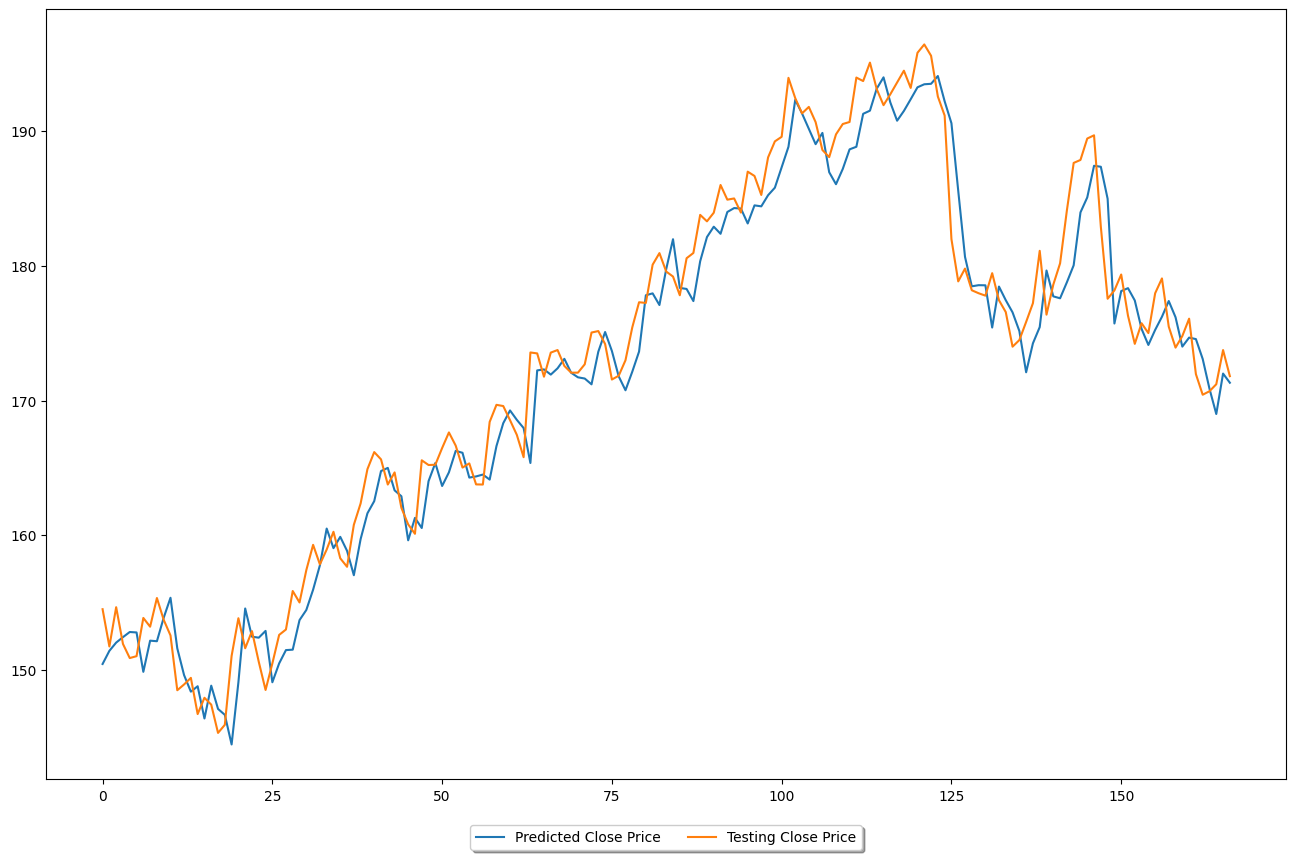

In [38]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()